**CORAL APPROACH**
---

Sun, B., et al. "Correlation alignment for unsupervised domain adaptation." In Domain Adaptation in Computer Vision Applications (pp. 153-171). Springer, Cham, 2017.

**Methodolgy:**
- The method is based on the idea of aligning the second-order statistics of source and target distributions.
- we want to transform MNIST images to look like SVHN images, so that the classifier trained on the transformed MNIST images can be directly applied to SVHN images.
- we will resize MNIST 28x28x1 images to 32x32x3 images to match the size of SVHN images.
- we will normalise MNIST and SVHN and get their covariance matrices. 
Note: covaraince matrix = M.t * M = correlation matrix with normalised data
- we wighten the source images (with MNIST covariance matrix) and then recolor them with target images (with SVHN covariance matrix).
following this algorithm :<br><br>

**CORAL for Unsupervised Domain Adaptation**<br>
Require Source data $D_s$, Target data $D_t$<br>
Ensure Adjusted Source data $D_a$<br>
State $C_s \gets \text{cov}(D_s) + \epsilon \cdot I$<br>
State $C_t \gets \text{cov}(D_t) + \epsilon \cdot I$<br>
State $D_s' \gets D_s \cdot C_s^{-\frac{1}{2}}$ \ Whitening source<br>
State $D_a \gets D_s' \cdot C_t^{\frac{1}{2}}$ \ Re-coloring with target covariance<br>
State \Return $D_a$



In [1]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader, ConcatDataset, Subset

import matplotlib.pyplot as plt
import IPython.display
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from PIL import Image

In [2]:
# DEFINE DEVICE

if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
print(device)

cuda


**0/ DATA PREPROCESSING**
---

In [3]:
# GET COVARIANCE MATRICES

#------------------------------------------------
# Compute the MNIST and SVHN mean and standard 
# deviation on the training set
#------------------------------------------------

def calculate_mean_std(loader, num_channels=3):
    channel_sum = torch.zeros(num_channels).to(device)
    channel_squared_sum = torch.zeros(num_channels).to(device)
    num_elements = 0

    for data, _ in loader:
        data = data.to(device)
        channel_sum += data.sum(dim=[0, 2, 3])
        channel_squared_sum += (data ** 2).sum(dim=[0, 2, 3])
        num_elements += data.size(0) * data.size(2) * data.size(3)

    mean = channel_sum / num_elements
    std = (channel_squared_sum / num_elements - mean ** 2) ** 0.5
    return mean, std

transform_mnist = transforms.Compose([
    transforms.Resize((32, 32), interpolation=Image.NEAREST),
    transforms.ToTensor(),
])

# Extract MNIST and SVHN datasets
MNIST_train = datasets.MNIST(root='./mnist_data/', train=True, transform = transform_mnist, download=True)
SVHN_train = datasets.SVHN(root='./svhn_data/', split='train', transform = transforms.ToTensor(), download=True)

# Create DataLoaders for MNIST and SVHN datasets
batch_size = 1024  # Adjust as needed
MNIST_train_loader = DataLoader(MNIST_train, batch_size=batch_size, shuffle=False)
SVHN_train_loader = DataLoader(SVHN_train, batch_size=batch_size, shuffle=False)

mnist_mean, mnist_std = calculate_mean_std(MNIST_train_loader, num_channels=1)
print(f"MNIST mean: {mnist_mean.cpu().numpy()}, MNIST std: {mnist_std.cpu().numpy()}")
svhn_mean_channels, svhn_std_channels = calculate_mean_std(SVHN_train_loader, num_channels=3) # vectors of dim 3 for 3 channels
svhn_mean = torch.mean(svhn_mean_channels) # scalar
variance_channels = svhn_std_channels ** 2
variance = torch.mean(variance_channels)
svhn_std = torch.sqrt(variance)
print(f"SVHN mean: [{svhn_mean}] , SVHN std: [{svhn_std}]")

#------------------------------------------------
# Normalise and flatten the MNIST and SVHN  dataset
# with real mean and standard deviation
#------------------------------------------------


Using downloaded and verified file: ./svhn_data/train_32x32.mat
MNIST mean: [0.12876366], MNIST std: [0.30613112]
SVHN mean: [0.45141881704330444] , SVHN std: [0.19870111346244812]


**2/ NORMALIZATION & COVARIANCE MATRIX COMPUTATION**
---

In [4]:

# NORMALIZED DATA
#####################################

# MNIST
data = MNIST_train.data.to(device)
data = data.float() 
#reshape mnist data from 28x28 to 32x32 pixels
data = F.interpolate(data.unsqueeze(1), size=(32, 32), mode='nearest').squeeze(1)
data = data / 255
#print("mnist 32x32 shape",data.shape)
data = (data - mnist_mean) / mnist_std
mnist_norm_np_flat = data.reshape(data.shape[0], -1).cpu().numpy()

# SVHN grayscale (by averaging 3 channels into 1)
data = SVHN_train.data /255
#print(type(data))
data = torch.tensor(data, dtype=torch.float32).to(device)
data = torch.mean(data, axis=1)    # reduce to 1 channel
data = (data - svhn_mean) / svhn_std
data = data.reshape(data.shape[0], -1)
svhn_gray_norm_np_flat = data.cpu().numpy()

# SVHN  
data = SVHN_train.data / 255
data = torch.tensor(data, dtype=torch.float32).to(device)
data = (data - svhn_mean) / svhn_std
svhn_norm_np = data.cpu().numpy()
data = data.reshape(data.shape[0], -1)
svhn_norm_np_flat = data.cpu().numpy()

print("\nNormalised MNIST min, max & shape    :",mnist_norm_np_flat.shape, mnist_norm_np_flat.min(),mnist_norm_np_flat.max(), type(mnist_norm_np_flat))
print("Normalised SVHN gray min, max & shape:",svhn_gray_norm_np_flat.shape, svhn_gray_norm_np_flat.min(), svhn_gray_norm_np_flat.max(), type(svhn_gray_norm_np_flat))
print("Normalised SVHN min, max & shape     :",svhn_norm_np_flat.shape, svhn_norm_np_flat.min(),svhn_norm_np_flat.max(),type(svhn_norm_np_flat))



Normalised MNIST min, max & shape    : (60000, 1024) -0.42061603 2.845958 <class 'numpy.ndarray'>
Normalised SVHN gray min, max & shape: (73257, 1024) -2.2718484 2.760836 <class 'numpy.ndarray'>
Normalised SVHN min, max & shape     : (73257, 3072) -2.2718484 2.760836 <class 'numpy.ndarray'>


In [5]:
#check normalisatoin for Red Green Blue channel of SVHN

print("\nSVHN (x3) mean, std   :",np.round(np.mean(svhn_norm_np_flat),8), np.std(svhn_norm_np_flat), svhn_norm_np_flat.shape)
print("- SVHN RED mean , std :",np.mean(svhn_norm_np_flat[:,:1024]), np.std(svhn_norm_np_flat[:,:1024]), svhn_norm_np_flat[:,:1024].shape)
print("- SVHN GREEN mean, std:",np.mean(svhn_norm_np_flat[:,1024:2048]), np.std(svhn_norm_np_flat[:,1024:2048]), svhn_norm_np_flat[:,1024:2048].shape)
print("- SVHN BLUE mean, std : ",np.mean(svhn_norm_np_flat[:,2048:]), np.std(svhn_norm_np_flat[:,2084,]), svhn_norm_np_flat[:,2048:].shape)


SVHN (x3) mean, std   : -3.2e-07 1.0029685 (73257, 3072)
- SVHN RED mean , std : -0.06913253 0.9966227 (73257, 1024)
- SVHN GREEN mean, std: -0.03849547 1.0116478 (73257, 1024)
- SVHN BLUE mean, std :  0.10762704 1.017517 (73257, 1024)


scale 2.845958


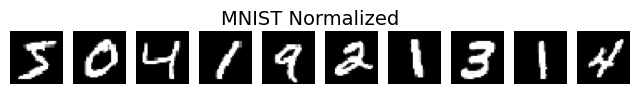

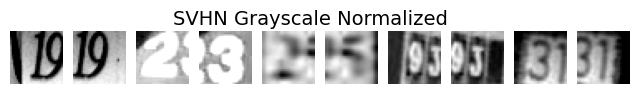

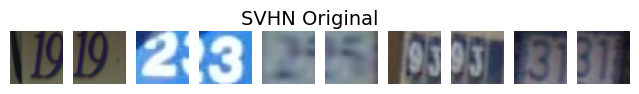

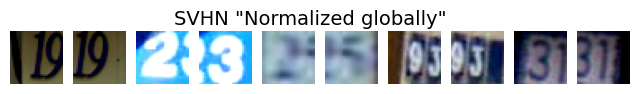

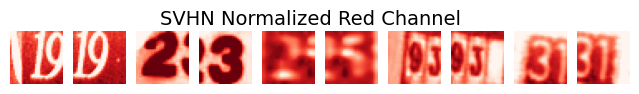

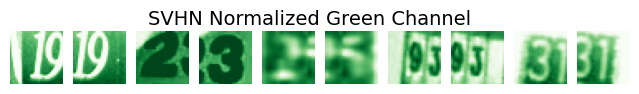

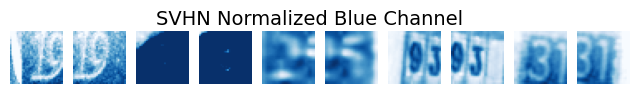

In [6]:
########################################################
# print images to check normalisation
# values range from -inf to +inf => need to scale to 0-1
########################################################

def plot_images(images, title, color ='gray', scaled = 1):
    fig, axs = plt.subplots(1, 10, figsize=(8, 1))
    # standardize the range of the images with min or max
    for i in range(10):
        if scaled == 1:
            scaled_image = (images[i]/scale +0.5)
            # print('min max:', np.min(scaled_image),' - ', np.max(scaled_image))
            # klip the values to 0-1	
            scaled_image[scaled_image > 1] = 1
            scaled_image[scaled_image < 0] = 0
        else:
            scaled_image = images[i]
        axs[i].imshow(scaled_image, cmap= color) # scales images to range 0-1
        axs[i].axis('off')
    plt.suptitle(title, fontsize=14)
    plt.show()

high = max( np.max(mnist_norm_np_flat) , np.max(svhn_gray_norm_np_flat) , np.max(svhn_norm_np_flat) )
low = min( np.min(mnist_norm_np_flat) , np.min(svhn_gray_norm_np_flat), np.min(svhn_norm_np_flat) )
scale = max(abs(high), abs(low))
print("scale", scale)

# MNIST
mnist_norm_np = mnist_norm_np_flat.reshape(-1, 32, 32)
plot_images(mnist_norm_np, 'MNIST Normalized')

# SVHN grayscale
svhn_gray_norm_np = svhn_gray_norm_np_flat.reshape(-1, 32, 32)
plot_images(svhn_gray_norm_np, 'SVHN Grayscale Normalized')

# SVHN
svhn_np_transpose = SVHN_train.data.transpose((0, 2, 3, 1))/255
plot_images(svhn_np_transpose, 'SVHN Original', scaled = 0)

# SVHN
svhn_norm_np_transpose = svhn_norm_np.transpose((0, 2, 3, 1))
plot_images(svhn_norm_np_transpose, 'SVHN "Normalized globally"')
#show red channel in red, green in green and blue in blue
plot_images(svhn_norm_np_transpose[:,:,:,0], 'SVHN Normalized Red Channel', color ='Reds')
plot_images(svhn_norm_np_transpose[:,:,:,1], 'SVHN Normalized Green Channel', color ='Greens')
plot_images(svhn_norm_np_transpose[:,:,:,2], 'SVHN Normalized Blue Channel', color ='Blues')


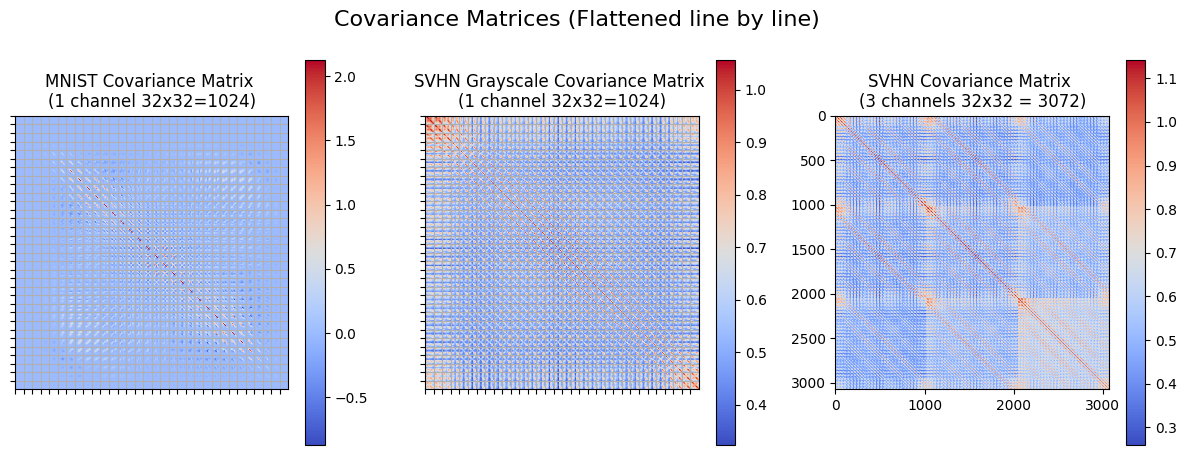

In [7]:
# SHOW 3 CORRELATION MATRICES (FLATTENED)
##########################################

cov_mnist_norm = np.cov(mnist_norm_np_flat, rowvar=False)
cov_svhn_gray_norm = np.cov(svhn_gray_norm_np_flat, rowvar=False)
cov_svhn_norm = np.cov(svhn_norm_np_flat, rowvar=False)

# covariance matrix is correlation matrix beacause the data is normalised

# Create a figure with subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

# MNIST Correlation Matrix
ax = axs[0]  # First subplot for MNIST
im = ax.imshow(cov_mnist_norm, cmap='coolwarm', interpolation='none')
ax.grid(True)
ax.set_xticks(np.arange(0, 1024, 32))
ax.set_yticks(np.arange(0, 1024, 32))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title('MNIST Covariance Matrix \n(1 channel 32x32=1024)')
fig.colorbar(im, ax=ax)

# SVHN grayscale Correlation Matrix
ax = axs[1]  # Second subplot for SVHN grayscale
im = ax.imshow(cov_svhn_gray_norm, cmap='coolwarm', interpolation='none')
ax.grid(True)
ax.set_xticks(np.arange(0, 1024, 32))
ax.set_yticks(np.arange(0, 1024, 32))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title('SVHN Grayscale Covariance Matrix \n(1 channel 32x32=1024)')
fig.colorbar(im, ax=ax)

# SVHN Correlation Matrix
ax = axs[2]  # Third subplot for SVHN
im = ax.imshow(cov_svhn_norm, cmap='coolwarm', interpolation='none')
ax.set_title('SVHN Covariance Matrix \n(3 channels 32x32 = 3072)')
fig.colorbar(im, ax=ax)

# Display the subplots
plt.suptitle('Covariance Matrices (Flattened line by line)', fontsize=16)
plt.show()

**3/ APPLYING CORAL METHOD**
---
With the normalised data, we can now apply the CORAL method to align the source and target distributions. 

The steps are as follows:<br>
1/ Compute the square root of the inverse of the source covariance matrix.<br>
2/ Compute the whitened source data.<br>
3/ Compute the square root of the target covariance matrix.<br>
4/ Compute the aligned source data.<br>

In [8]:
# WHITENING MATRIX
##################

def get_whitening_matrix(cov, epsilon=1e-5):
    '''Compute the whitening matrix from the covariance matrix
    input : covariance matrix of SOURCE dataset, epsilon
    output : whitening matrix (size of covariance matrix)
    '''
    # Compute the eigenvalues and eigenvectors of the covariance matrix
    eigvals, eigvecs = np.linalg.eigh(cov + epsilon * np.eye(cov.shape[0]))

    # Compute the inverse of the square root of the eigenvalues
    inv_sqrt_eigvals = 1.0 / np.sqrt(eigvals)

    # Construct the whitening matrix
    whitening_matrix = np.dot(np.dot(eigvecs, np.diag(inv_sqrt_eigvals)), eigvecs.T)

    return whitening_matrix

def get_whitened_data(data, mean, whitening_matrix):
    '''denoise the data by centering and whitening it
    Input: flattenned np.array data, mean, whitening_matrix
    '''
    # Center the data
    centered_data = data - mean

    # Apply the whitening matrix
    whitened_data = np.dot(centered_data, whitening_matrix)

    return whitened_data   

def get_coloring_matrix(target_cov):
    # Compute the square root of the target covariance matrix
    eigvals, eigvecs = np.linalg.eigh(target_cov)
    eigvals[eigvals < 0] = 0  # Numerical stability
    sqrt_eigvals = np.diag(np.sqrt(eigvals))
    coloring_matrix = np.dot(eigvecs, np.dot(sqrt_eigvals, eigvecs.T))

    return coloring_matrix

def get_colored_data(data, mean, coloring_matrix):
    '''denoise the data by centering and coloring it
    Input: flattenned np.array data, mean, coloring_matrix
    '''
    # DO NOT center the data

    # Apply the coloring matrix
    colored_data = np.dot(data, coloring_matrix)

    return colored_data

# After whitening and coloring the mean and std of new data needs to be checked and adjusted
# shifts or scaling may have occured due to the use of eigenvalues and eigenvectors (not unique)

def adjust_mean_std_to_SVHN(data, data_mean, data_std, target_mean, target_std):
    """
    Adjusts the input data (NumPy array) to have the specified target mean and standard deviation,
    ensuring the output is a NumPy array.

    :param data: Input data as a NumPy array.
    :param data_mean: Mean of the input data.
    :param data_std: Standard deviation of the input data.
    :param target_mean: Target mean for the adjusted data.
    :param target_std: Target standard deviation for the adjusted data.
    :return: Adjusted data as a NumPy array.
    """

    print("colored data - shape, mean, std, min, max:",data.shape, np.mean(data), np.std(data), np.min(data), np.max(data))

    # Convert mean and std to numpy arrays for broadcasting if they aren't already
    data_mean = np.array(data_mean)
    data_std = np.array(data_std)
    target_mean = np.array(target_mean)
    target_std = np.array(target_std)
    
    # Adjust the data
    adjusted_data = ((data - data_mean) * (target_std / data_std)) + target_mean
    
    # Optionally, you can clip the adjusted data to ensure it's within a valid range, like [0, 1]
    adjusted_data = np.clip(adjusted_data, 0, 1)
    
    print("adjusted data - shape, mean, std, min, max:",adjusted_data.shape, np.mean(adjusted_data), np.std(adjusted_data), np.min(adjusted_data), np.max(adjusted_data))
    
    return adjusted_data


starting whitening MNIST
mnist_norm_np_flat shape: (60000, 1024)
mnist_whitened : (60000, 1024)
mnist colorized gray shape: (60000, 1024) <class 'numpy.ndarray'>
mnist colorized mean, std, min max: -0.21519401793381968 0.9070017103334552 -10.596598930383307 106.81564549081261
colored data - shape, mean, std, min, max: (60000, 1024) -0.21519401793381968 0.9070017103334552 -10.596598930383307 106.81564549081261
adjusted data - shape, mean, std, min, max: (60000, 1024) 0.44746498625811393 0.17149899709670852 0.0 1.0


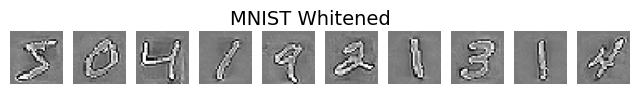

mnist_colorized_gray_img shape: (60000, 32, 32) <class 'numpy.ndarray'>


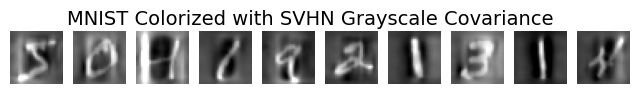

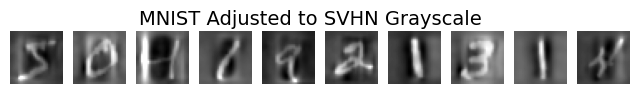

In [9]:
# APPLY CORAL METHOD TO MNIST WITH GRAYSCALE SVHN
#################################################

# Whiten MNIST
#------------------------------------------------ 
print("starting whitening MNIST")
print('mnist_norm_np_flat shape:',mnist_norm_np_flat.shape)
whitening_matrix = get_whitening_matrix(cov_mnist_norm)
mnist_whitened = get_whitened_data(mnist_norm_np_flat, np.mean(mnist_norm_np_flat, axis=0), whitening_matrix)
print('mnist_whitened :',mnist_whitened.shape)

# Color with GRAYSCALE SVHN
#------------------------------------------------
coloring_matrix_gray = get_coloring_matrix(cov_svhn_gray_norm)
mnist_colorized_gray = get_colored_data(mnist_whitened, np.mean(svhn_gray_norm_np_flat, axis=0), coloring_matrix_gray)
print('mnist colorized gray shape:',mnist_colorized_gray.shape, type(mnist_colorized_gray))
print('mnist colorized mean, std, min max:',np.mean(mnist_colorized_gray), np.std(mnist_colorized_gray), np.min(mnist_colorized_gray), np.max(mnist_colorized_gray))

# Adjust the data to the SVHN distirbution
#------------------------------------------------

mnist_like_svhn_gray = adjust_mean_std_to_SVHN(mnist_colorized_gray, 
                        np.mean(mnist_colorized_gray), np.std(mnist_colorized_gray), 
                        svhn_mean.cpu().numpy(), svhn_std.cpu().numpy())


# show images
#------------------------------------------------
# whitened MNIST
mnist_whitened_img = mnist_whitened.reshape(-1, 32, 32)
plot_images(mnist_whitened_img, 'MNIST Whitened')

# colorized MNIST with SVHN grayscale
mnist_colorized_gray_img = mnist_colorized_gray.reshape(-1, 32, 32)
print("mnist_colorized_gray_img shape:",mnist_colorized_gray_img.shape, type(mnist_colorized_gray_img))
plot_images(mnist_colorized_gray_img, 'MNIST Colorized with SVHN Grayscale Covariance')

# MNIST adjusted to SVHN grayscale
mnist_like_svhn_gray_img = mnist_like_svhn_gray.reshape(-1, 32, 32)
plot_images(mnist_like_svhn_gray_img, 'MNIST Adjusted to SVHN Grayscale')

# SAVE MNIST COLORIZED WITH SVHN GRAYSCALE
############################################
import pickle
with open('mnist_colorized_gray.pkl', 'wb') as f:
    pickle.dump(mnist_colorized_gray_img, f)



mnist_colorized_gray_img shape: (60000, 32, 32, 3) <class 'numpy.ndarray'>
colored data - shape, mean, std, min, max: (60000, 32, 32) -0.21519401793381968 0.9070017103334552 -10.596598930383307 106.81564549081261
adjusted data - shape, mean, std, min, max: (60000, 32, 32) 0.4339334110214141 0.1715288329625065 0.0 1.0
colored data - shape, mean, std, min, max: (60000, 32, 32) -0.21519401793381968 0.9070017103334552 -10.596598930383307 106.81564549081261
adjusted data - shape, mean, std, min, max: (60000, 32, 32) 0.43978858509664726 0.17354042490791013 0.0 1.0
colored data - shape, mean, std, min, max: (60000, 32, 32) -0.21519401793381968 0.9070017103334552 -10.596598930383307 106.81564549081261
adjusted data - shape, mean, std, min, max: (60000, 32, 32) 0.4686577314844827 0.16936132039294585 0.0 1.0


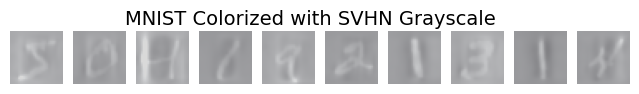

: 

: 

: 

In [10]:
# create a new dataset with the colorized images

class ColorizedMNIST(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = data
        self.target = target
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        target = self.target[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample, target

# Check MNIST colorized with SVHN grayscale if good format
#---------------------------------------------------------
# duplicate to 3 channels
mnist_colorized_gray_img = np.repeat(mnist_colorized_gray_img[:, :, :, np.newaxis], 3, axis=3)
print("mnist_colorized_gray_img shape:",mnist_colorized_gray_img.shape, type(mnist_colorized_gray_img))

# adjust each channel to have the same mean and std as each SVHN channels
for i in range(3):
    mnist_colorized_gray_img[:,:,:,i] = adjust_mean_std_to_SVHN(mnist_colorized_gray_img[:,:,:,i], 
                        np.mean(mnist_colorized_gray_img[:,:,:,i]), np.std(mnist_colorized_gray_img[:,:,:,i]), 
                        svhn_mean_channels[i].cpu().numpy(), svhn_std_channels[i].cpu().numpy())
#show final images
plot_images(mnist_colorized_gray_img, 'MNIST Colorized with SVHN Grayscale')


# SAVE MNIST COLORIZED WITH SVHN GRAYSCALE
############################################
import pickle
with open('mnist_colorized_gray.pkl', 'wb') as f:
    pickle.dump(mnist_colorized_gray_img, f)




In [ ]:

# SAVE COLORIZED MNIST DATASET WITH TORCH DATASETS
############################################

# create a dataset with the colorized images
colorized_mnist = ColorizedMNIST(mnist_colorized_gray_img, MNIST_train.targets, transform=transforms.ToTensor())
print("colorized_mnist dataset shape & type :",colorized_mnist.data.shape, type(colorized_mnist.data))

torch.save(colorized_mnist, 'colorized_mnist.pth')

**4/ APPLYING CORAL METHOD WITH 3 CHANNELS**
---
We will apply the CORAL method to the 3 channels of the images and add randomness to the transformation.

mnist_colorised shape (60000, 1, 1024)
mnist_colorized shape (60000, 3, 1024)
starting colorizing MNIST
channel : 0
cov_channel_i shape (1024, 1024)
svhn_mean_i shape ()
channel : 1
cov_channel_i shape (1024, 1024)
svhn_mean_i shape ()
channel : 2
cov_channel_i shape (1024, 1024)
svhn_mean_i shape ()
mnist_colorized shape BEFORE RESHAPE (60000, 3, 1024)
mnist_colorized shape AFTER RESHAPE (60000, 32, 32, 3)


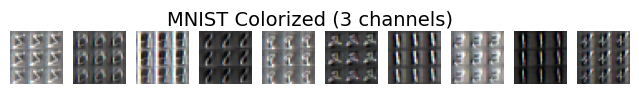

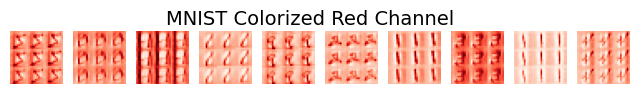

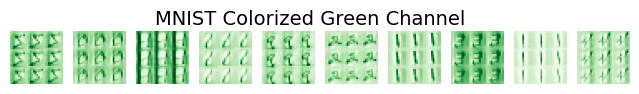

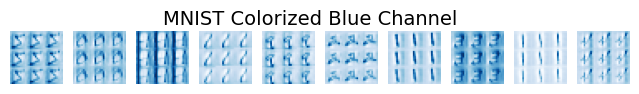

In [ ]:
# create mnist_colorized with 3 channels
mnist_colorised = mnist_whitened.reshape(-1, 1, 1024)
print("mnist_colorised shape",mnist_colorised.shape)
mnist_colorized = np.repeat(mnist_colorised, 3, axis=1) # 32 x 32 x 3 channels
print("mnist_colorized shape",mnist_colorized.shape)

# Color MNIST 
print("starting colorizing MNIST")
for i in range(3):
    print("channel :",i)
    cov_channel_i = cov_svhn_norm[i*1024:(i+1)*1024,i*1024:(i+1)*1024] # to get each covaraince matrix on the diagonal
    coloring_matrix_i = get_coloring_matrix(cov_channel_i)
    print("cov_channel_i shape",cov_channel_i.shape)
    svhn_mean_i = svhn_mean_channels[i].cpu().numpy()
    print("svhn_mean_i shape",svhn_mean_i.shape)
    mnist_colorized[:, i, :] = get_colored_data(mnist_colorized[:, i, :],svhn_mean_i , coloring_matrix_i) # one channel at a time

print("mnist_colorized shape BEFORE RESHAPE",mnist_colorized.shape)
mnist_colorized_img = mnist_colorized.reshape(-1, 32, 32, 3)
print("mnist_colorized shape AFTER RESHAPE",mnist_colorized_img.shape)
plot_images(mnist_colorized_img, 'MNIST Colorized (3 channels)')
plot_images(mnist_colorized_img[:,:,:,0], 'MNIST Colorized Red Channel', color ='Reds')
plot_images(mnist_colorized_img[:,:,:,1], 'MNIST Colorized Green Channel', color ='Greens')
plot_images(mnist_colorized_img[:,:,:,2], 'MNIST Colorized Blue Channel', color ='Blues')

In [ ]:
mnist_colorized[:, :, :].shape

(60000, 3, 1024)

In [ ]:
# DOWNLOAD DATA 

# DOWNLOAD, RESIZE & NORMALIZE MNIST DATASET  (32x32x3 instead of originl 28x28x1)
'''
from torchvision import datasets, transforms
import torch

# Define the transform to resize the image to 32x32 and replicate to 3 channels
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize to 32x32
    transforms.Grayscale(num_output_channels=3),  # Convert to RGB by replicating channels
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize each channel (assuming mean 0.5, std 0.5 for simplicity)
])

# Download and load the dataset with the defined transform
train_dataset_source = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
test_dataset_source = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=True)

# DOWNLOAD, (RESIZE &) NORMALISE, SVHN DATASET (Stret View House Numbers)
train_dataset_target = datasets.SVHN(root='./svhn_data/', split='train', transform=transform, download=True) # transform to insure same shape and normalisation
test_dataset_target = datasets.SVHN(root='./svhn_data/', split='test', transform=transform, download=True)'''


Using downloaded and verified file: ./svhn_data/train_32x32.mat
Using downloaded and verified file: ./svhn_data/test_32x32.mat


MNIST size (60000, 28, 28)
SVHN grayscale shape (73257, 32, 32)
SVHN shape (73257, 3, 32, 32)


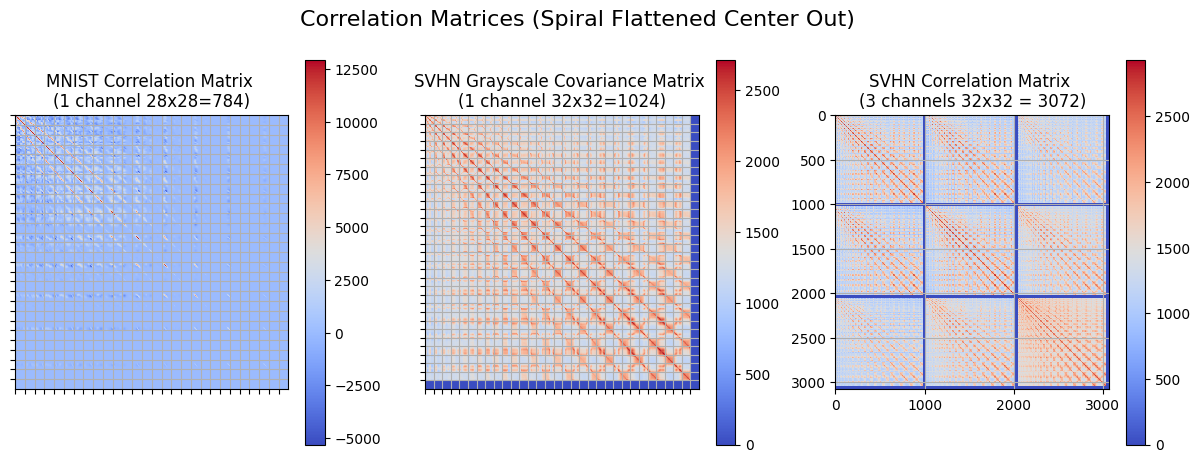

In [ ]:
# SPRIRAL FLATTENING
#####################################

def spiral_flatten_center_out(image):
    N = image.shape[0]
    output = np.zeros(N*N, dtype=image.dtype)
    x, y = N // 2 - 1, N // 2 - 1  # Start from the center for even dimensions
    dx, dy = 0, 1  # Initial direction: right
    steps = 1  # Initial steps in the current direction
    step_changes = 0  # Counts how many times we've changed steps
    index = 0  # Index for the output array

    for i in range(N * N):
        # Check if current position is valid
        if 0 <= x < N and 0 <= y < N:
            output[index] = image[x, y]
            index += 1
        # Move to the next position
        x, y = x + dx, y + dy
        steps -= 1
        # Change direction and update steps
        if steps == 0:
            dx, dy = -dy, dx  # Rotate direction
            step_changes += 1
            if step_changes % 2 == 0:
                steps = step_changes // 2 + 1
            else:
                steps = (step_changes + 1) // 2

    return output

#MNIST

data_np = MNIST_train.data.numpy()
print('MNIST size',data_np.shape)
n_images, height, width = data_np.shape
data_spiral = np.zeros((n_images, height * width), dtype=data_np.dtype) # Apply the spiral flattening to each image
for i in range(n_images):
    data_spiral[i, :] = spiral_flatten_center_out(data_np[i, :, :])
cov_mnist_spiral = np.cov(data_spiral, rowvar=False)

# SVHN grayscale (by adding 3 channels into 1)
data_np = SVHN_train.data # numpy array
data_np = np.mean(data_np, axis=1)
print("SVHN grayscale shape", data_np.shape)
n_images, height, width = data_np.shape
data_spiral = np.zeros((n_images, height * width), dtype=data_np.dtype) # Apply the spiral flattening to each channel of each image
for i in range(n_images):
    data_spiral[i, :] = spiral_flatten_center_out(data_np[i, :, :])
cov_SVHN_gray_spiral = np.cov(data_spiral, rowvar=False)

#SVHN

data_np = SVHN_train.data
print("SVHN shape", data_np.shape)
n_images, channels, height, width = data_np.shape
data_spiral = np.zeros((n_images, channels * height * width), dtype=data_np.dtype) # Apply the spiral flattening to each channel of each image
for i in range(n_images):
    for j in range(channels):  # data_np is [i,3, :, :] is an image
        data_spiral[i, j * height * width:(j + 1) * height * width] = spiral_flatten_center_out(data_np[i, j, :, :])
cov_SVHN_spiral = np.cov(data_spiral, rowvar=False)

# SHOW 3 CORRELATION MATRICES (SPIRAL FLATTENED CENTER OUT)

# Create a figure with subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

# MNIST Correlation Matrix
ax = axs[0]  # First subplot for MNIST
im = ax.imshow(cov_mnist_spiral, cmap='coolwarm', interpolation='none')
ax.grid(True)
ax.set_xticks(np.arange(0, 784, 28))
ax.set_yticks(np.arange(0, 784, 28))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title('MNIST Correlation Matrix \n(1 channel 28x28=784)')
fig.colorbar(im, ax=ax)

# SVHN grayscale Correlation Matrix
ax = axs[1]  # Second subplot for SVHN grayscale
im = ax.imshow(cov_SVHN_gray_spiral, cmap='coolwarm', interpolation='none')
ax.grid(True)
ax.set_xticks(np.arange(0, 1024, 32))
ax.set_yticks(np.arange(0, 1024, 32))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title('SVHN Grayscale Covariance Matrix \n(1 channel 32x32=1024)')
fig.colorbar(im, ax=ax)

# SVHN Correlation Matrix
ax = axs[2]  # Third subplot for SVHN
im = ax.imshow(cov_SVHN_spiral, cmap='coolwarm', interpolation='none')
ax.grid(True)
ax.set_title('SVHN Correlation Matrix \n(3 channels 32x32 = 3072)')
fig.colorbar(im, ax=ax)

# Display the subplots
plt.suptitle('Correlation Matrices (Spiral Flattened Center Out)', fontsize=16)
plt.show()



In [ ]:
##############################################################
# TO APPLY WHITENING & COLORIZATION TO THE ORIGINAL IMAGES
##############################################################

#trasnformation to upload flattened preprocessed data
class FlattenTransform:
    def __call__(self, x):
        return x.view(-1)
    
transform_mnist = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor value in [0, 1]
    transforms.Resize((32, 32), interpolation=Image.NEAREST),  # Resize to 32x32
    transforms.Normalize(mnist_mean, mnist_std),  # Normalize with real mean and standard deviation
    FlattenTransform(),  # Flattens the images
])

transform_svhn = transforms.Compose([
    transforms.ToTensor(), # Convert to tensor value in [0, 1]
    transforms.Normalize(svhn_mean, svhn_std), # Normalize with real mean and standard deviation
    FlattenTransform(),  # Flattens the images
])

MNIST_train_flat = datasets.MNIST(root='./mnist_data/', train=True, transform = transform_mnist, download=True)
SVHN_train_flat = datasets.SVHN(root='./svhn_data/', split='train', transform = transform_svhn, download=True)

MNIST_train_loader_flat = DataLoader(MNIST_train_flat, batch_size=batch_size, shuffle=False)
SVHN_train_loader_flat = DataLoader(SVHN_train_flat, batch_size=batch_size, shuffle=False)

print("MNIST shape: ", MNIST_train_flat.data.shape)
print("SVHN shape: ", SVHN_train_flat.data.shape)

Using downloaded and verified file: ./svhn_data/train_32x32.mat
MNIST shape:  torch.Size([60000, 28, 28])
SVHN shape:  (73257, 3, 32, 32)
